# Xarray Preprocessing

Xarray is a great package for multi-dimmensional datasets. But there are no standard way to go from xarray to ML packages. 

In [1]:
import xarray as xr
import numpy as np

import pyproj
import verde as vd
import xrft

import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.units import units

import harmonica as hm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

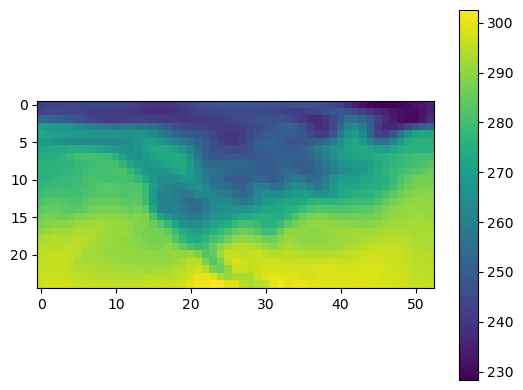

In [3]:
plt.imshow(ds.air.isel(time=1))
plt.colorbar()

## Lets make some Pre-processing functions

#### Graident

Note: there are some upcoming improvements to metpy that might improve on this workflow

In [4]:
%%time

ds['y_diff'] = ds.differentiate("lat")["air"]
ds['x_diff'] = ds.differentiate("lon")["air"]

#calc'ing the second order
ds['y_diff2order'] = ds.differentiate("lat", edge_order=2)["air"]
ds['x_diff2order'] = ds.differentiate("lon", edge_order=2)["air"]
ds

CPU times: user 106 ms, sys: 29 ms, total: 135 ms
Wall time: 134 ms


<xarray.Dataset>
Dimensions:       (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat           (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon           (lon) float32 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time          (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air           (time, lat, lon) float32 241.2 242.5 243.5 ... 296.2 295.7
    y_diff        (time, lat, lon) float32 -1.04 -0.8 -0.48 ... -0.32 -0.2 -0.2
    x_diff        (time, lat, lon) float32 0.52 0.46 0.3 ... -0.2 -0.16 -0.2
    y_diff2order  (time, lat, lon) float32 -0.32 -0.14 0.118 ... -0.4 -0.18 -0.2
    x_diff2order  (time, lat, lon) float32 0.58 0.46 0.3 ... -0.2 -0.16 -0.24
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

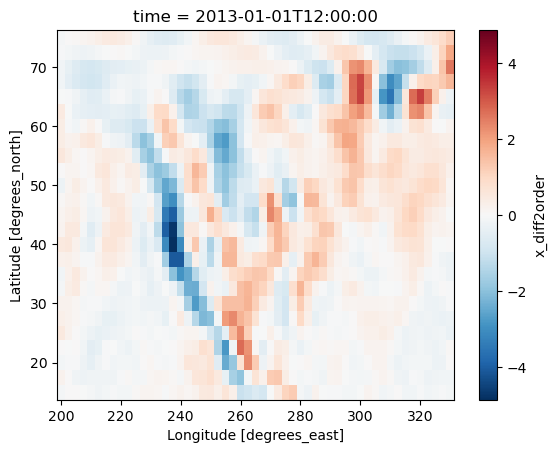

In [5]:
ds['x_diff2order'].isel(time=2).plot()

### Min-Max, Processing from -1 to 1, centering on the median 

In [6]:
a = [1,3,5,7,8,9,11]
a  = np.asarray(a)

In [7]:
def normalize(q, min=-1, max=1):
    """
    Takes an array and:
    1. Min, Max normilization from -1 to 1
    2. Centering on the median
    """
    # center on the median
    data = q
    _std = (data - data.min()) / (data.max() - data.min())
    scaled = _std * (max - min) + min

    scaled = scaled - np.median(scaled)
    return scaled

In [8]:
d = xr.apply_ufunc(normalize, ds)
d

<xarray.Dataset>
Dimensions:       (time: 2920, lat: 25, lon: 53)
Coordinates:
  * lat           (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon           (lon) float32 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time          (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air           (time, lat, lon) float32 -0.9129 -0.8859 ... 0.228 0.2176
    y_diff        (time, lat, lon) float32 -0.0613 -0.03484 ... 0.03131 0.03131
    x_diff        (time, lat, lon) float32 0.08851 0.07868 ... -0.02295 -0.0295
    y_diff2order  (time, lat, lon) float32 0.01616 0.03232 ... 0.02873 0.02694
    x_diff2order  (time, lat, lon) float32 0.09834 0.07868 ... -0.02295 -0.03606

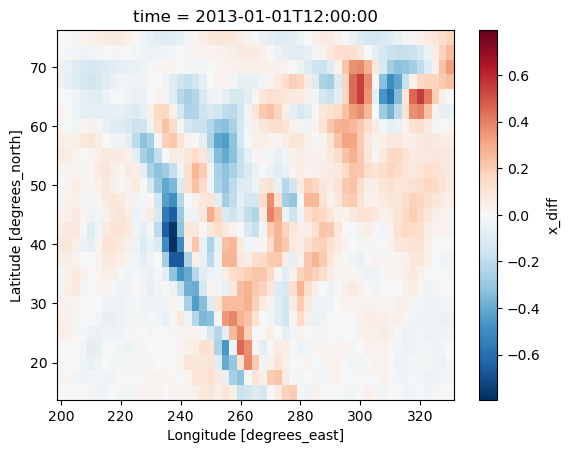

In [9]:
#ds.isel(time=2).air.plot()
d.isel(time=2).x_diff.plot()

## Harmonica -> using FFT's to do a derivative

From this example: https://www.fatiando.org/harmonica/latest/gallery/upward_derivative.html#sphx-glr-gallery-upward-derivative-py

/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)



Upward derivative:
 <xarray.DataArray (lat: 25, lon: 53)>
array([[ 0.13817534,  0.08580503,  0.09311621, ...,  0.09536855,
         0.09720002,  0.14477495],
       [ 0.08655609,  0.03894216,  0.03882823, ...,  0.02746665,
         0.02606012,  0.07512786],
       [ 0.08449925,  0.0270629 ,  0.03125503, ...,  0.03681973,
         0.02409715,  0.0750591 ],
       ...,
       [-0.22494253, -0.08228327, -0.09264439, ..., -0.24322062,
        -0.23291278, -0.39693616],
       [-0.34074749, -0.1436692 , -0.15186338, ..., -0.18450513,
        -0.17240622, -0.37689424],
       [-0.52010778, -0.33596473, -0.34361925, ..., -0.37610134,
        -0.35129741, -0.52514992]])
Coordinates:
  * lat      (lat) float64 15.0 17.5 20.0 22.5 25.0 ... 65.0 67.5 70.0 72.5 75.0
  * lon      (lon) float64 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0


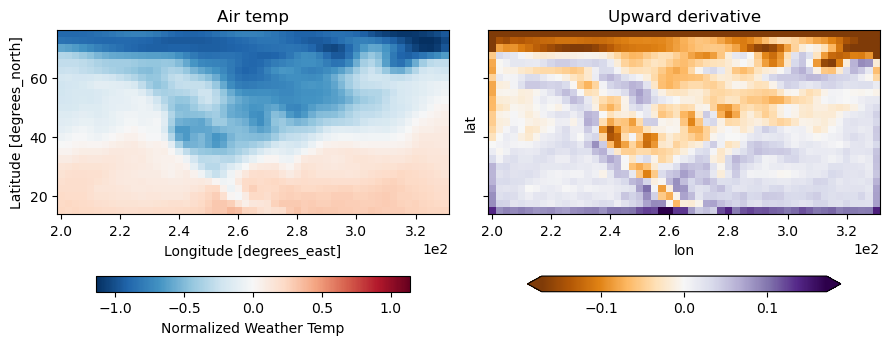

In [11]:

# Fetch the sample total-field magnetic anomaly data from Great Britain
#grid = d.isel(time=2).air
grid = d.isel(time=2).air
# Pad the grid to increase accuracy of the FFT filter
pad_width = {
    "lon": grid.lon.size // 5,
    "lat": grid.lat.size // 5,
}
# grid = grid.drop_vars("upward")  # drop extra coordinates due to bug in xrft.pad
grid_padded = xrft.pad(grid, pad_width)

# Compute the upward derivative of the grid
deriv_upward = hm.derivative_upward(grid_padded)

# Unpad the derivative grid
deriv_upward = xrft.unpad(deriv_upward, pad_width)

# Show the upward derivative
print("\nUpward derivative:\n", deriv_upward)

# Plot original magnetic anomaly and the upward derivative
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(9, 8), sharex=True, sharey=True
)

# Plot the magnetic anomaly grid
grid.plot(
    ax=ax1,
    cbar_kwargs={"label": "Normalized Weather Temp", "location": "bottom", "shrink": 0.8, "pad": 0.08},
)
ax1.set_title("Air temp")

# Plot the upward derivative
scale = np.quantile(np.abs(deriv_upward), q=0.95)  # scale the colorbar
deriv_upward.plot(
    ax=ax2,
    vmin=-scale,
    vmax=scale,
    cmap="PuOr",
    cbar_kwargs={ "location": "bottom", "shrink": 0.8, "pad": 0.08},
)
ax2.set_title("Upward derivative")

# Scale the axes
for ax in (ax1, ax2):
    ax.set_aspect("equal")

# Set ticklabels with scientific notation
ax1.ticklabel_format(axis="x", style="sci", scilimits=(-2, 2))
ax1.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))

plt.tight_layout()
plt.show()